# Import libraries

In [ ]:
import numpy as np
np.random.seed(42)

import os
import glob
import cv2
import datetime
import pandas as pd
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

from collections import Counter

from keras.applications import xception
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report

import tensorflow as tf

from matplotlib import *
import matplotlib.pyplot as plt

import random

import json

# Connection with Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Variables

In [ ]:
seed = 42

# Functions

In [ ]:
def get_im_cv2(path):
  
    img = cv2.imread(path)

    resized = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)

    final_image = xception.preprocess_input(resized)

    return final_image

In [ ]:
def random_flip(image):
  return tf.image.random_flip_left_right(image, seed)

def random_saturation(image):
  lower = random.random()
  upper = random.random()
  while(lower > upper):
    upper = random.random()

  return tf.image.random_saturation(image, lower, upper, seed)


In [ ]:
def data_aumentation_flip(path):
    img = cv2.imread(path)
    img = random_flip(img)
    resized = cv2.resize(np.array(img), (224, 224), cv2.INTER_LINEAR)
    final_image = xception.preprocess_input(resized)
    return final_image

In [ ]:
def data_aumentation_sat(path):
    img = cv2.imread(path)
    img = random_saturation(img)
    resized = cv2.resize(np.array(img), (224, 224), cv2.INTER_LINEAR)
    final_image = xception.preprocess_input(resized)
    return final_image

In [ ]:
def load_train():

    X_train = []
    X_train_id = []
    y_train = []

    start_time = time.time()

    print('Read train images')

    folders = [ 'chromista', 
                'protozoa', 
                'animalia', 
                'mollusca', 
                'arachnida', 
                'insecta', 
                'aves', 
                'mammalia', 
                'amphibia', 
                'reptilia', 
                'actinopterygii', 
                'fungi', 
                'plantae']

    for fld in folders:

        index = folders.index(fld)

        print('Load folder {} - train (Index: {})'.format(fld, index))

        for year in (2018, 2019, 2020, 2021):

          print('Reading ' + str(year))
          
          files = os.listdir(os.path.join('/content/drive/MyDrive/natusphera', f'{year}_{fld}', ''))
          

          for fl in files:
              path_img = os.path.join('/content/drive/MyDrive/natusphera', f'{year}_{fld}', fl)

              img = get_im_cv2(path_img)
              X_train.append(img)
              X_train_id.append(fld)
              y_train.append(index)

              img = data_aumentation_flip(path_img)
              X_train.append(img)
              X_train_id.append(fld)
              y_train.append(index)

              img = data_aumentation_sat(path_img)
              X_train.append(img)
              X_train_id.append(fld)
              y_train.append(index)

    X_train = np.array(X_train, dtype = 'float32')
    y_train = np.array(y_train, dtype = 'int32')

    print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))

    return X_train, y_train, X_train_id

# Load train, test and validation datasets

In [ ]:
x_train, y_train, x_train_id = load_train()

Read train images
Load folder chromista - train (Index: 0)
Reading 2018
Reading 2019
Reading 2020
Reading 2021
Load folder protozoa - train (Index: 1)
Reading 2018
Reading 2019
Reading 2020
Reading 2021
Load folder animalia - train (Index: 2)
Reading 2018
Reading 2019
Reading 2020
Reading 2021
Load folder mollusca - train (Index: 3)
Reading 2018
Reading 2019
Reading 2020
Reading 2021
Load folder arachnida - train (Index: 4)
Reading 2018
Reading 2019
Reading 2020
Reading 2021
Load folder insecta - train (Index: 5)
Reading 2018
Reading 2019
Reading 2020
Reading 2021
Load folder aves - train (Index: 6)
Reading 2018
Reading 2019
Reading 2020
Reading 2021
Load folder mammalia - train (Index: 7)
Reading 2018
Reading 2019
Reading 2020
Reading 2021
Load folder amphibia - train (Index: 8)
Reading 2018
Reading 2019
Reading 2020
Reading 2021
Load folder reptilia - train (Index: 9)
Reading 2018
Reading 2019
Reading 2020
Reading 2021
Load folder actinopterygii - train (Index: 10)
Reading 2018
Readi

In [ ]:
print(Counter(y_train).keys())
print(Counter(y_train).values())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
dict_values([2148, 525, 2400, 2400, 2388, 2100, 2400, 2250, 1776, 2160, 2400, 2400, 2109])


In [ ]:
print(Counter(y_train).keys())
print(Counter(y_train).values())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
dict_values([2148, 525, 2400, 2400, 2388, 2100, 2400, 2250, 1776, 2160, 2400, 2400, 2109])


In [ ]:
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

# train is now 80% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=1-train_ratio, random_state=seed)

# test is now 10% of the initial data set
# validation is now 10% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=seed) 

# Modeling

In [ ]:
base_model = xception.Xception(weights = 'imagenet', include_top = False)

83697664/83683744 [==============================] - 0s 0us/step


In [ ]:
avg = GlobalAveragePooling2D()(base_model.output)

In [ ]:
output = Dense(13, activation = 'softmax')(avg)

In [ ]:
model = Model(inputs = base_model.input, outputs = output)

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
optimizer = SGD(lr=0.2, momentum=0.9, decay=0.01)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

Epoch 1/5
687/687 [==============================] - 301s 433ms/step - loss: 1.7771 - accuracy: 0.6275 - val_loss: 1.0818 - val_accuracy: 0.6748
Epoch 2/5
687/687 [==============================] - 293s 426ms/step - loss: 0.6657 - accuracy: 0.7848 - val_loss: 0.8155 - val_accuracy: 0.7458
Epoch 3/5
687/687 [==============================] - 296s 431ms/step - loss: 0.5401 - accuracy: 0.8259 - val_loss: 0.7894 - val_accuracy: 0.7509
Epoch 4/5
687/687 [==============================] - 295s 430ms/step - loss: 0.4901 - accuracy: 0.8452 - val_loss: 0.7392 - val_accuracy: 0.7582
Epoch 5/5
687/687 [==============================] - 323s 471ms/step - loss: 0.4631 - accuracy: 0.8572 - val_loss: 0.7230 - val_accuracy: 0.7640


In [ ]:
for layer in base_model.layers:
  layer.trainable = True

In [ ]:
optimizer = SGD(lr=0.1, momentum=0.9, decay=0.001)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

Epoch 1/5
687/687 [==============================] - 1845s 3s/step - loss: 2.1133 - accuracy: 0.2633 - val_loss: 1.9290 - val_accuracy: 0.3693
Epoch 2/5
687/687 [==============================] - 1813s 3s/step - loss: 1.2214 - accuracy: 0.6023 - val_loss: 1.1710 - val_accuracy: 0.6300
Epoch 3/5
687/687 [==============================] - 2058s 3s/step - loss: 0.6131 - accuracy: 0.8015 - val_loss: 1.0003 - val_accuracy: 0.6803
Epoch 4/5
687/687 [==============================] - 3029s 4s/step - loss: 0.2837 - accuracy: 0.9091 - val_loss: 0.5595 - val_accuracy: 0.8514
Epoch 5/5
687/687 [==============================] - 3018s 4s/step - loss: 0.1245 - accuracy: 0.9605 - val_loss: 0.4313 - val_accuracy: 0.8893


# Saving the model and the results

In [ ]:
model.save(os.path.join('/content/drive/MyDrive/natusphera', 'first_model_data_aumentation')) 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/natusphera/first_model_data_aumentation/assets


In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/natusphera/first_model_data_aumentation/')

In [ ]:
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history.history
# Save it under the form of a json file
json.dump(history_dict, open('/content/drive/MyDrive/natusphera/first_model_data_aumentation/history', 'w'))

In [ ]:
history_dict = json.load(open('/content/drive/MyDrive/natusphera/first_model_data_aumentation/history', 'r'))

# Results

In [ ]:
def plot_accuracy(history):

  # fig = figure.Figure(figsize=(10,5))

  # plot accuracy
  # plt.subplot(221)
  plt.plot(history['accuracy'], 'mo--', label = 'accuracy')
  plt.plot(history['val_accuracy'], 'co--', label = 'validation accuracy')
  plt.title('Accuracy: Train vs Validation')
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.legend()

In [ ]:
def plot_loss(history):

  # fig = figure.Figure(figsize=(10,5))

  # plot loss function
  # plt.subplot(222)
  plt.plot(history['loss'], 'mo--', label = 'accuracy')
  plt.plot(history['val_loss'], 'co--', label = 'validation loss')
  plt.title('Loss: Train vs Validation')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend()

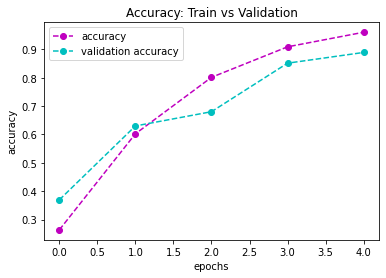

In [ ]:
plot_accuracy(history_dict)

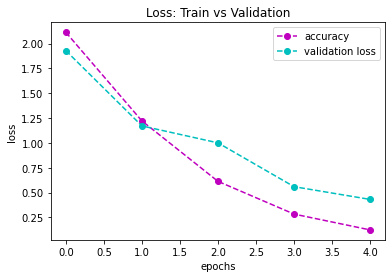

In [ ]:
plot_loss(history_dict)

In [ ]:
predictions = new_model.predict(x_test)
pred_labels = np.argmax(predictions, axis=1)

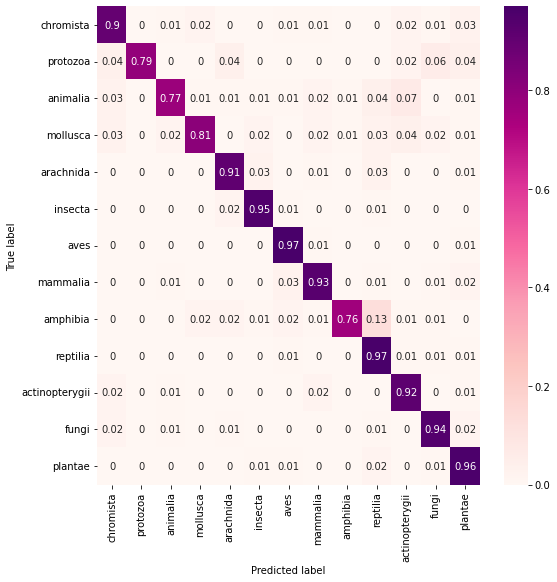

In [ ]:
classes = [ 'chromista', 
                'protozoa', 
                'animalia', 
                'mollusca', 
                'arachnida', 
                'insecta', 
                'aves', 
                'mammalia', 
                'amphibia', 
                'reptilia', 
                'actinopterygii', 
                'fungi', 
                'plantae']

con_mat = tf.math.confusion_matrix(y_test,pred_labels).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

import seaborn as sns

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.RdPu)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

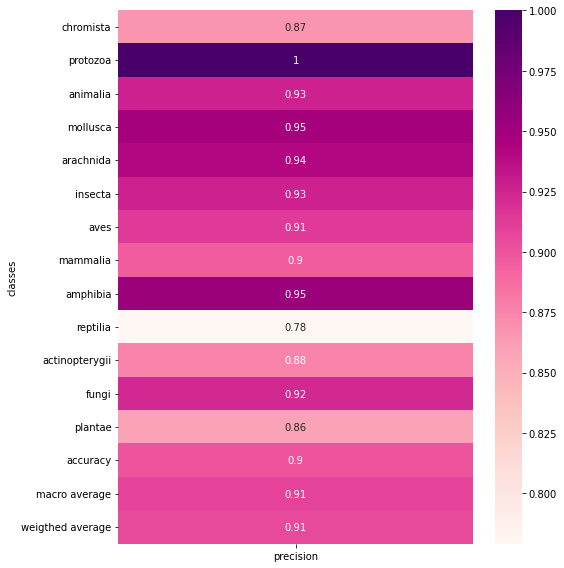

In [ ]:
report = classification_report(y_test, pred_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
classes.append('accuracy')
classes.append('macro average')
classes.append('weigthed average')
df['classes'] = classes
df = df.reset_index().drop(columns = 'index').set_index('classes')

figure = plt.figure(figsize=(8, 8))
sns.heatmap(df[['precision']], annot=True,cmap=plt.cm.RdPu)
plt.tight_layout()
plt.show()

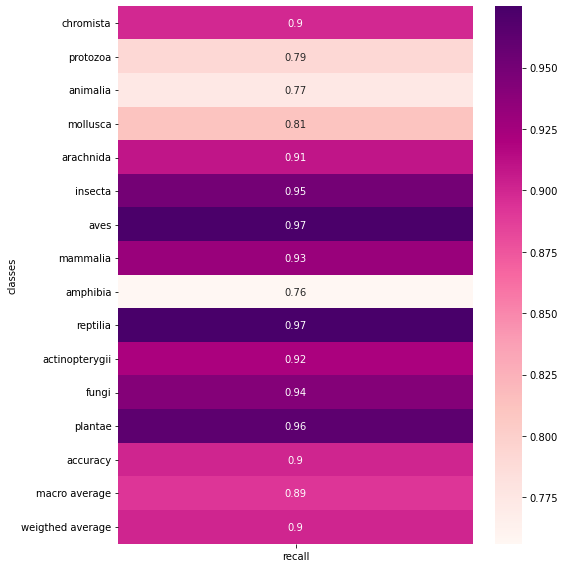

In [ ]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(df[['recall']], annot=True,cmap=plt.cm.RdPu)
plt.tight_layout()
plt.show()

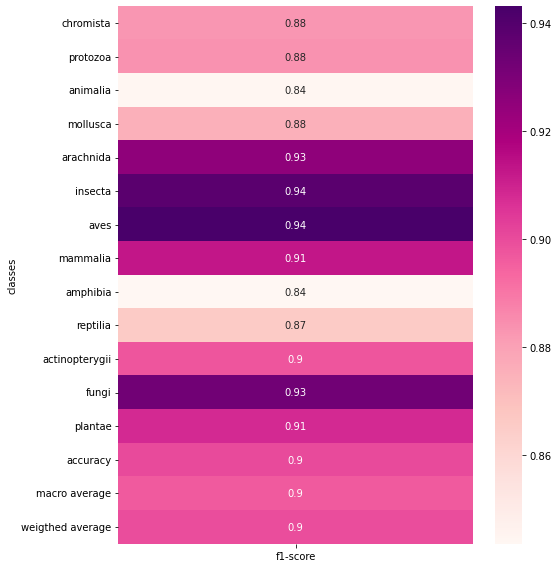

In [ ]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(df[['f1-score']], annot=True,cmap=plt.cm.RdPu)
plt.tight_layout()
plt.show()

In [ ]:
test_loss = model.evaluate(x_test, y_test)

86/86 [==============================] - 45s 522ms/step - loss: 0.3833 - accuracy: 0.9035


In [ ]:
test_loss_new = new_model.evaluate(x_test, y_test)

86/86 [==============================] - 46s 522ms/step - loss: 0.3833 - accuracy: 0.9035


In [ ]:
predictions = model.predict(x_test)
pred_labels = np.argmax(predictions, axis=1)

In [ ]:
predictions_new = model.predict(x_test)
pred_labels_new = np.argmax(predictions_new, axis=1)

In [ ]:
print(classification_report(y_test,pred_labels))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       189
           1       1.00      0.81      0.90        48
           2       0.93      0.79      0.85       231
           3       0.96      0.80      0.87       255
           4       0.95      0.92      0.94       266
           5       0.93      0.95      0.94       242
           6       0.92      0.97      0.95       230
           7       0.89      0.93      0.91       231
           8       0.95      0.77      0.86       164
           9       0.78      0.97      0.87       199
          10       0.87      0.92      0.89       243
          11       0.93      0.95      0.94       258
          12       0.86      0.96      0.91       190

    accuracy                           0.90      2746
   macro avg       0.91      0.90      0.90      2746
weighted avg       0.91      0.90      0.90      2746

